#downloading data

In [1]:
import os
import json

# 1. ENTER YOUR DETAILS HERE
# (Keep the quotes! e.g., "my_username")
kaggle_username = "adityabahira"
kaggle_key = "b23c7a2497e265a3eadda7900378ffb7"

# 2. Create the dictionary
token = {"username": kaggle_username, "key": kaggle_key}

# 3. Create the hidden folder
!mkdir -p ~/.kaggle

# 4. Write the file manually
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

# 5. Secure it
!chmod 600 ~/.kaggle/kaggle.json

print("Success! Key created manually.")

Success! Key created manually.


In [2]:
# Test the connection
!kaggle datasets list --sort-by votes

ref                                                           title                                                      size  lastUpdated                 downloadCount  voteCount  usabilityRating  
------------------------------------------------------------  --------------------------------------------------  -----------  --------------------------  -------------  ---------  ---------------  
jessicali9530/animal-crossing-new-horizons-nookplaza-dataset  Animal Crossing New Horizons Catalog                     590770  2021-06-08 15:05:09.513000          83596      56245  0.88235295       
mlg-ulb/creditcardfraud                                       Credit Card Fraud Detection                            69155672  2018-03-23 01:17:27.913000        1052656      12803  0.85294116       
allen-institute-for-ai/CORD-19-research-challenge             COVID-19 Open Research Dataset Challenge (CORD-19)  19724979450  2022-06-06 19:39:40.923000         198114      11278  0.88235295       
shiva

In [3]:
!kaggle datasets download -d jacksoncrow/stock-market-dataset
!unzip -q stock-market-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/jacksoncrow/stock-market-dataset
License(s): CC0-1.0
 99% 515M/522M [00:02<00:00, 205MB/s]
100% 522M/522M [00:02<00:00, 253MB/s]


#data loading and cleaning

In [4]:
import pandas as pd

def load_ticker(csv_path):
    """
    Loads and cleans a single ticker CSV.
    """
    df = pd.read_csv(csv_path)

    #convert Date column to datetime
    df["Date"]=pd.to_datetime(df["Date"])

    #sort by Date
    df=df.sort_values(by="Date",ascending=True)

    #set Date as index
    df=df.set_index("Date")
    #keep only OHLCV + Adj Close
    df=df[["Open","High","Low","Close","Adj Close","Volume"]]

    return df

In [5]:
import os

ticker=["AAPL","AMZN","GOOGL","MSFT","NVDA","QQQ"]

data={}
for t in ticker:
  stock_path = f"/content/stocks/{t}.csv"
  etf_path = f"/content/etfs/{t}.csv"

  path = None
  if os.path.exists(stock_path):
    path = stock_path
  elif os.path.exists(etf_path):
    path = etf_path
  else:
    print(f"Warning: CSV for {t} not found in either stocks or etfs folder. Skipping.")
    continue # Skip to the next ticker

  data[t] = load_ticker(path)

In [6]:
# getting range of each ticker
for t, df in data.items():
    print(t, df.index.min(), df.index.max())


AAPL 1980-12-12 00:00:00 2020-04-01 00:00:00
AMZN 1997-05-15 00:00:00 2020-04-01 00:00:00
GOOGL 2004-08-19 00:00:00 2020-04-01 00:00:00
MSFT 1986-03-13 00:00:00 2020-04-01 00:00:00
NVDA 1999-01-22 00:00:00 2020-04-01 00:00:00
QQQ 1999-03-10 00:00:00 2020-04-01 00:00:00


In [7]:
# Finding number of null values in tickers and list down those rows with respect to ticker

for t, df in data.items():
  num_na = df.isna().sum().sum()
  print(f"Ticker: {t}, Number of NaNs: {num_na}")
  if num_na != 0:
    print(data[t][data[t].isna().any(axis=1)])

Ticker: AAPL, Number of NaNs: 0
Ticker: AMZN, Number of NaNs: 0
Ticker: GOOGL, Number of NaNs: 0
Ticker: MSFT, Number of NaNs: 0
Ticker: NVDA, Number of NaNs: 6
            Open  High  Low  Close  Adj Close  Volume
Date                                                 
2001-09-12   NaN   NaN  NaN    NaN        NaN     NaN
Ticker: QQQ, Number of NaNs: 0


In [8]:
#removing null values (as data is huge,we are just gonna remove row)

for t, df in data.items():
  num_na = df.isna().sum().sum()
  if num_na != 0:
    data[t]=data[t].dropna()


In [9]:
for t, df in data.items():
  num_na = df.isna().sum().sum()
  print(f"Ticker: {t}, Number of NaNs: {num_na}")
  if num_na != 0:
    print(data[t][data[t].isna().any(axis=1)])

Ticker: AAPL, Number of NaNs: 0
Ticker: AMZN, Number of NaNs: 0
Ticker: GOOGL, Number of NaNs: 0
Ticker: MSFT, Number of NaNs: 0
Ticker: NVDA, Number of NaNs: 0
Ticker: QQQ, Number of NaNs: 0


In [10]:
# get common dates across all tickers
common_dates = None

for t, df in data.items():
    dates = set(df.index)
    if common_dates is None:
        common_dates = dates
    else:
        common_dates = common_dates.intersection(dates)

common_dates = sorted(common_dates)

for t in data:
    data[t] = data[t].loc[common_dates]

for t, df in data.items():
    print(t, df.shape)


AAPL (3932, 6)
AMZN (3932, 6)
GOOGL (3932, 6)
MSFT (3932, 6)
NVDA (3932, 6)
QQQ (3932, 6)


# Indicators

In [11]:
# return

for t,df in data.items():
  df['ret']=df['Adj Close'].pct_change()

#removing first row as it will be null return
for t,df in data.items():
  data[t]=data[t].iloc[1:]

In [12]:
#return z-score

w_return=63

for t, df in data.items():
  rolling_mean=df['ret'].rolling(w_return).mean().shift(1)
  rolling_sd=df['ret'].rolling(w_return).std().shift(1)

  df['ret_z']=(df['ret']-rolling_mean)/rolling_sd

In [13]:
# volum z-score

import numpy as np

w_volume=21

for t,df in data.items():
  log_v=np.log(df['Volume'])

  vol_mean=log_v.rolling(w_volume).mean().shift(1)
  vol_sd=log_v.rolling(w_volume).std().shift(1)

  df['volz']=(log_v-vol_mean)/vol_sd

In [14]:
# intraday range percentile

for t, df in data.items():
    df["range"] = (df["High"] - df["Low"]) / df["Close"]

def rolling_percentile(series, window):
    return series.rolling(window).apply(
        lambda x: (x.iloc[-1] > x[:-1]).mean() * 100,
        raw=False
    )

w_range = 63

for t, df in data.items():
    df["range_pct"] = rolling_percentile(df["range"], w_range).shift(1)

In [15]:
for t, df in data.items():
    df['ticker']=t

In [16]:
#warm_up (as first w_range days (which is 63) gonna give null values)
for t in data:
    data[t] = data[t].iloc[w_range:]


In [17]:
for t, df in data.items():
    assert df[["ret_z", "volz", "range_pct"]].isna().sum().sum() == 0

In [18]:
data['GOOGL']

,Open,High,Low,Close,Adj Close,Volume,ret,ret_z,volz,range,range_pct,ticker
Date,,,,,,,,,,,,
2004-11-18,85.230232,87.297295,82.947945,83.853851,83.853851,33225900,-0.028754,-1.019858,0.141279,0.051868,70.967742,GOOGL
2004-11-19,84.634636,85.075073,83.343346,84.784782,84.784782,17521000,0.011102,0.096257,-1.784687,0.020425,77.419355,GOOGL
2004-11-22,82.317314,84.834831,80.735733,82.632629,82.632629,24711600,-0.025384,-0.903270,-0.657832,0.049606,8.064516,GOOGL
2004-11-23,84.069069,85.500504,83.333336,83.843842,83.843842,24801700,0.014658,0.187712,-0.592224,0.025848,72.580645,GOOGL
2004-11-24,87.497498,88.693695,86.341339,87.467468,87.467468,30531400,0.043219,0.974171,0.269159,0.026894,25.806452,GOOGL
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-26,1114.719971,1171.479980,1092.030029,1162.920044,1162.920044,3828100,0.055645,1.790406,0.412588,0.068319,87.096774,GOOGL
2020-03-27,1127.469971,1151.050049,1104.000000,1110.260010,1110.260010,3139700,-0.045283,-1.303414,-0.581765,0.042378,90.322581,GOOGL
2020-03-30,1132.640015,1151.000000,1098.489990,1146.310059,1146.310059,2936800,0.032470,1.040058,-0.895776,0.045808,74.193548,GOOGL


# Rule based Anomaly

In [19]:
full_df = pd.concat(data.values())

In [20]:
def apply_simple_rules(row):

    reasons = []
    # Create a list to store the detailed reasons based on conditions
    detailed_reasons = []

    # Check for Price Anomalies
    if abs(row['ret_z']) > 2.5:
        if row['ret'] < 0:
            reasons.append('Crash')
            detailed_reasons.append(f"ret_z < -2.5")
        else:
            reasons.append('Spike')
            detailed_reasons.append(f"ret_z > 2.5")

    # Check for Volume Anomalies
    if row['volz'] > 2.5:
        reasons.append('Volume_Shock')
        detailed_reasons.append(f"volz > 2.5")

    if len(reasons) > 0:
        # Return simple_flag, anomaly_type (e.g., 'Crash+Volume_Shock'), and the detailed 'why' string
        return 1, "+".join(reasons), " ; ".join(detailed_reasons)
    else:
        return 0, "Normal", "Normal Conditions"

# Apply it to the dataframe
print("Applying rules...")
# Assign the three outputs of apply_simple_rules to three new columns
full_df[['simple_flag', 'anomaly_type', 'why']] = full_df.apply(
    lambda row: pd.Series(apply_simple_rules(row)), axis=1
)

# Check the results (# of reason matches with number of type of anomaly )
print("\nAnomaly Type Counts:")
print(full_df['anomaly_type'].value_counts())
print("\nSimple Rule Why Counts:")
print(full_df['why'].value_counts().head(6))

Applying rules...

Anomaly Type Counts:
anomaly_type
Normal                21913
Volume_Shock            559
Crash                   234
Spike                   225
Crash+Volume_Shock      154
Spike+Volume_Shock      123
Name: count, dtype: int64

Simple Rule Why Counts:
why
Normal Conditions            21913
volz > 2.5                     559
ret_z < -2.5                   234
ret_z > 2.5                    225
ret_z < -2.5 ; volz > 2.5      154
ret_z > 2.5 ; volz > 2.5       123
Name: count, dtype: int64


# KMean anomaly

In [21]:
from sklearn.preprocessing import StandardScaler

# 1. ensure the index is actual Datetime objects
full_df.index = pd.to_datetime(full_df.index)

# 2. Split Data by Year using the INDEX
# Train = 2018, Validation = 2019, Test = 2020 (Q1)
train_df = full_df[full_df.index.year == 2018].copy()
val_df   = full_df[full_df.index.year == 2019].copy()
test_df  = full_df[full_df.index.year == 2020].copy()

print(f"Train (2018): {len(train_df)} rows")
print(f"Val   (2019): {len(val_df)} rows")
print(f"Test  (2020): {len(test_df)} rows")

# 3.Features
feature_cols = ['ret_z', 'volz', 'range_pct']

# 4. Fit Scaler ONLY on Training Data
scaler = StandardScaler()
scaler.fit(train_df[feature_cols])

# 5. Transform all sets
X_train = scaler.transform(train_df[feature_cols])
X_val   = scaler.transform(val_df[feature_cols])
X_test  = scaler.transform(test_df[feature_cols])

Train (2018): 1506 rows
Val   (2019): 1512 rows
Test  (2020): 378 rows


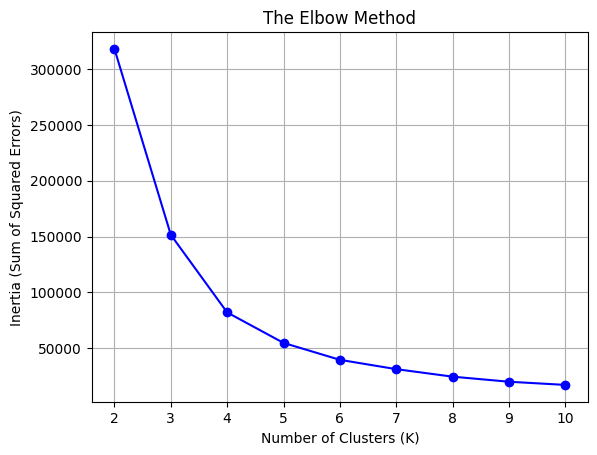

Elbow Method Plot: Notice the 'elbow' at K=5 or 6. This is the optimal number of clusters!


In [22]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


inertia_values = []
k_range = range(2, 11)  # We will test K from 2 to 10

for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(train_df[feature_cols])
    inertia_values.append(kmeans.inertia_) # inertia_ stores the SSE

# Plot K vs. Inertia
plt.figure()
plt.plot(k_range, inertia_values, 'bo-')
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia (Sum of Squared Errors)')
plt.xticks(k_range)
plt.grid(True)
plt.show()

print("Elbow Method Plot: Notice the 'elbow' at K=5 or 6. This is the optimal number of clusters!")

In [23]:
# 1. Train K-Means
k = 6
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
kmeans.fit(X_train) # Fit on 2018 only

# 2. Define a function to calculate distance to nearest centroid
def get_distances(model, X):
    # transform() returns distance to ALL clusters. We take the min.
    all_distances = model.transform(X)
    min_distances = all_distances.min(axis=1)
    return min_distances

# 3. Establish the Threshold (Tau) from Training Data
train_dist = get_distances(kmeans, X_train)
threshold = np.percentile(train_dist, 97.5) # Top 2.5% are anomalies
print(f"Anomaly Threshold (Distance): {threshold:.4f}")

# 4. Detect Anomalies in Test Set (2020)
test_dist = get_distances(kmeans, X_test)
test_anomalies = test_dist > threshold

# Add these results back to the dataframe for easy viewing
test_df['kmeans_dist'] = test_dist
test_df['kmeans_flag'] = test_anomalies.astype(int)

# 5. Review the Catch
print("Anomalies found in 2020 (Test Set):")
print(test_df[test_df['kmeans_flag'] == 1][['ticker', 'ret', 'anomaly_type']].head(10))

Anomaly Threshold (Distance): 1.8900
Anomalies found in 2020 (Test Set):
           ticker       ret        anomaly_type
Date                                           
2020-03-02   AAPL  0.093101               Spike
2020-03-13   AAPL  0.119808               Spike
2020-03-16   AAPL -0.128647               Crash
2020-01-30   AMZN  0.006825        Volume_Shock
2020-01-31   AMZN  0.073791  Spike+Volume_Shock
2020-01-02  GOOGL  0.021868              Normal
2020-01-17  GOOGL  0.020246              Normal
2020-02-03  GOOGL  0.034772  Spike+Volume_Shock
2020-02-24  GOOGL -0.042873               Crash
2020-02-27  GOOGL -0.054313               Crash


# DBSCAN Anomaly

In [24]:
from sklearn.cluster import DBSCAN

# 1. Define DBSCAN Model
# values (eps=0.5, min_samples=10) are starting guesses. we will tune them after.
dbscan = DBSCAN(eps=0.5, min_samples=10)

# 2. Fit on Training Data (2018)
labels_2020 = dbscan.fit_predict(X_test)

# 3. Add results to the Test DataFrame
test_df['dbscan_label'] = labels_2020

# 4. Check results
# -1 means "Anomaly" (Noise)
# 0, 1, 2... are cluster IDs
anomalies_dbscan = test_df[test_df['dbscan_label'] == -1]

print(f"DBSCAN found {len(anomalies_dbscan)} anomalies in 2020.")
print(anomalies_dbscan[['ticker', 'ret', 'anomaly_type']].head())

DBSCAN found 160 anomalies in 2020.
           ticker       ret anomaly_type
Date                                    
2020-01-02   AAPL  0.022816       Normal
2020-01-08   AAPL  0.016086       Normal
2020-01-17   AAPL  0.011071       Normal
2020-01-21   AAPL -0.006777       Normal
2020-01-22   AAPL  0.003570       Normal


#tuning

In [25]:
len(anomalies_dbscan)

160

In [26]:
import numpy as np
import pandas as pd

# 1. Calculate Distances for 2019 (Validation Set)

val_dist = get_distances(kmeans, X_val)

print("--- TUNING K-MEANS ON 2019 DATA ---")
print(f"Total Validation Days: {len(X_val)}")

# 2. Try different Threshold Percentiles (q)

percentiles_to_test = [90, 93, 95, 96, 97, 98, 99, 99.5]

results_km = []

for q in percentiles_to_test:
    thresh = np.percentile(train_dist, q)

    # B. Apply to 2019 Data
    num_anomalies = np.sum(val_dist > thresh)
    flag_rate = (num_anomalies / len(val_dist)) * 100

    results_km.append({
        'q (Percentile)': q,
        'Threshold': thresh,
        'Anomalies Found': num_anomalies,
        'Flag Rate (%)': round(flag_rate, 2)
    })

# 3. Show the Table
df_km_tuning = pd.DataFrame(results_km)
print(df_km_tuning)
print("\nTarget: We want Flag Rate between 2% and 8%.")

--- TUNING K-MEANS ON 2019 DATA ---
Total Validation Days: 1512
   q (Percentile)  Threshold  Anomalies Found  Flag Rate (%)
0            90.0   1.332192              158          10.45
1            93.0   1.466890              105           6.94
2            95.0   1.608387               73           4.83
3            96.0   1.702605               60           3.97
4            97.0   1.806860               47           3.11
5            98.0   2.007670               37           2.45
6            99.0   2.440208               21           1.39
7            99.5   2.856599               10           0.66

Target: We want Flag Rate between 2% and 8%.


we can choose q from 97 to 93 lets go with q=95

In [27]:
from sklearn.cluster import DBSCAN

print("--- TUNING DBSCAN ON 2019 DATA ---")

# We will try a range of eps values
eps_values = [0.1, 0.3, 0.5, 0.7, 1.0, 1.5, 2.0, 2.5]
min_samples =[5,10,15,20]

results_db = []

for min in min_samples:
  for eps in eps_values:
    # 1. Fit DBSCAN on 2019 Data
    db = DBSCAN(eps=eps, min_samples=min)
    labels = db.fit_predict(X_val)

    # 2. Count Noise (-1)
    num_anomalies = np.sum(labels == -1)
    flag_rate = (num_anomalies / len(X_val)) * 100

    results_db.append({
        'eps': eps,
        'min_sample':min,
        'Anomalies Found': num_anomalies,
        'Flag Rate (%)': round(flag_rate, 2)
    })

# 3. Show the Table
df_db_tuning = pd.DataFrame(results_db)
print(df_db_tuning)
print("\nTarget: Look for a Flag Rate between 2% and 8%.")

--- TUNING DBSCAN ON 2019 DATA ---
    eps  min_sample  Anomalies Found  Flag Rate (%)
0   0.1           5             1493          98.74
1   0.3           5              320          21.16
2   0.5           5               81           5.36
3   0.7           5               33           2.18
4   1.0           5               16           1.06
5   1.5           5                6           0.40
6   2.0           5                3           0.20
7   2.5           5                2           0.13
8   0.1          10             1512         100.00
9   0.3          10              593          39.22
10  0.5          10              143           9.46
11  0.7          10               51           3.37
12  1.0          10               22           1.46
13  1.5          10                8           0.53
14  2.0          10                3           0.20
15  2.5          10                2           0.13
16  0.1          15             1512         100.00
17  0.3          15          

for eps=0.7 and min_sample=10 flag rate is 3.37 which is between 2% and 8% so let eps=0.7 and min_sample=10

In [28]:
# --- FINAL CONFIGURATION ---
# Based on tuning:
FINAL_Q_PERCENTILE = 95
FINAL_EPSILON = 0.5
FINAL_MIN_SAMPLES = 5

# test

In [29]:
# 1. K-MEANS FINAL SCORING
train_dist = get_distances(kmeans, X_train) # Uses the 2018 model
final_threshold = np.percentile(train_dist, FINAL_Q_PERCENTILE)

print(f"Final K-Means Threshold (Distance): {final_threshold:.4f}")

# Score 2020 Data
test_dist = get_distances(kmeans, X_test)
test_df['kmeans_flag'] = (test_dist > final_threshold).astype(int)
test_df['kmeans_dist'] = test_dist # Save distance for the report


# 2. DBSCAN FINAL SCORING
db_final = DBSCAN(eps=FINAL_EPSILON, min_samples=FINAL_MIN_SAMPLES)
test_df['dbscan_label'] = db_final.fit_predict(X_test)

# Convert labels to a binary flag (0 = Normal, 1 = Anomaly)
# In DBSCAN, -1 is the label for "Noise" (Anomaly)
test_df['dbscan_flag'] = (test_df['dbscan_label'] == -1).astype(int)


# 3. COMBINE FLAGS
# Union: It is an anomaly if EITHER model says so (High Recall)
test_df['final_anomaly'] = test_df[['simple_flag', 'kmeans_flag', 'dbscan_flag']].max(axis=1)

print("Final Scoring Complete.")
print(f"Total Anomalies in 2020: {test_df['final_anomaly'].sum()} out of {len(test_df)} stock-days.")

Final K-Means Threshold (Distance): 1.6084
Final Scoring Complete.
Total Anomalies in 2020: 113 out of 378 stock-days.


#Finale Query

In [30]:
def query_date(target_date):
    """
    User-facing tool: Prints a "Health Card" for a specific date.
    """
    # 1. Validate Date
    if target_date not in test_df.index:
        print(f"Error: Date {target_date} not found in Test Set (2020).")
        return

    # 2. Get Data
    day_data = test_df.loc[target_date]

    # 3. Market Context (Breadth)
    # How many stocks were green?
    breadth =(np.sum(day_data['ret'] > 0))/len(day_data['ret'])
    market_status = "STRESSED" if breadth < 0.3 else "Normal"

    print(f"========================================")
    print(f" DATE: {target_date} | STATUS: {market_status}")
    print(f" Market Breadth: {breadth:.2f} | {breadth:.2%} stocks up ")
    print(f"========================================")

    # 4. List Anomalies
    # Filter for rows where our final flag is 1
    anomalies = day_data[day_data['final_anomaly'] == 1].copy()

    if len(anomalies) == 0:
        print("No anomalies detected.")
    else:
        print(f"Found {len(anomalies)} Anomalies:\n")
        # Formating the output
        for ticker, row in anomalies.iterrows():
            # Determine WHY it was flagged
            reasons = []
            if row['simple_flag'] == 1: reasons.append(f"Rule({row['anomaly_type']})")
            if row['kmeans_flag'] == 1: reasons.append(f"KMeans(Dist={row['kmeans_dist']:.2f})")
            if row['dbscan_flag'] == 1: reasons.append("DBSCAN(Noise)")

            print(f"-> {row['ticker']:<5} | Return: {row['ret']:.2%} | Flags: {', '.join(reasons)}")

    #5. Daily Anomaly Card
    import os

    folder_name = "Daily Anomaly Card"
    path = os.path.join("/content/", folder_name)

    # Check if the folder already exists to avoid errors
    if not os.path.exists(path):
        os.mkdir(path)
        print(f"Folder '{folder_name}' created at {path}")
    else:
        print(f"Folder '{folder_name}' already exists")

    # anomaly card dataframe
    DAC_cols=['ticker','simple_flag','anomaly_type','ret','ret_z','volz','range_pct','why']
    card_df = day_data[DAC_cols].sort_index().copy()
    card_df.rename(columns={'simple_flag': 'flag'}, inplace=True)


    filename = f"Anomaly_Card_{target_date}.csv"
    file_path=path + f"/{filename}"
    card_df.to_csv(file_path)
    print(f"\nSaved to {file_path}")

    #6. Market-day report
    import os

    folder_name_m = "Market-Day Table"
    path_m = os.path.join("/content/", folder_name_m)

    # Check if the folder already exists to avoid errors
    if not os.path.exists(path_m):
        os.mkdir(path_m)
        print(f"Folder '{folder_name_m}' created at {path_m}")
    else:
        print(f"Folder '{folder_name_m}' already exists")

    #market-day df
    mark_dic={'Date':target_date,
              'Market_ret':f"{day_data['ret'].mean():.3f}",
              'Breadth':f"{breadth:.2f}",
              'Market_anomaly_flag':day_data['final_anomaly'].max()}
    market_df=pd.DataFrame([mark_dic])

    filename_m=f"Market-Day_Table_{target_date}.csv"
    file_path_m=path_m + f"/{filename_m}"
    market_df.to_csv(file_path_m)
    print(f"\nSaved to {file_path_m}")

In [31]:
def generate_monthly_report(year, month):
    """
    Creates the table requested in PDF Section 6.D.
    """
    # 1. Filter Data for the Month
    # We work on a copy to avoid warnings
    mask = (test_df.index.year == year) & (test_df.index.month == month)
    monthly_data = test_df[mask].copy()

    # 2. Filter for Anomalies Only
    anomalies = monthly_data[monthly_data['final_anomaly'] == 1].copy()

    if len(anomalies) == 0:
        print(f"No anomalies found in {year}-{month}")
        return

    # 3. Create the 'Type' Column
    def explain_flag(row):
        reasons = []
        if row['simple_flag']: reasons.append(row['anomaly_type'])
        if row['kmeans_flag']: reasons.append(f"KMeans_Dist({row['kmeans_dist']:.1f})")
        if row['dbscan_flag']: reasons.append("DBSCAN")
        return " + ".join(reasons)

    anomalies['Anomaly_Type'] = anomalies.apply(explain_flag, axis=1)

    # 4. Select Columns for the Report
    report_cols_selection = ['ticker','Anomaly_Type', 'ret_z', 'volz','simple_flag', 'why']
    report_df = anomalies[report_cols_selection].sort_index().copy()
    report_df.rename(columns={'simple_flag': 'flag'}, inplace=True)


    # Display
    print(f"--- MONTHLY REPORT: {year}-{month} ---")
    # Using simple markdown-style display
    print(report_df.to_markdown())

    # Optional: Save to CSV
    import os

    folder_name = "Monthly report"
    path = os.path.join("/content/", folder_name)

    # Check if the folder already exists to avoid errors
    if not os.path.exists(path):
        os.mkdir(path)
        print(f"Folder '{folder_name}' created at {path}")
    else:
        print(f"Folder '{folder_name}' already exists")

    filename = f"report_{year}_{month}.csv"
    file_path=path + f"/{filename}"
    report_df.to_csv(file_path)
    print(f"\nSaved to {file_path}")

#How to use final commands for finding anomaly

1) To get daily report use following command

- **query_date("YYYY-MM-DD")**
- example,  query_date('2020-03-16')


  it will generate date query, daily anomaly card (csv) and market_day table (csv)


---



---


2) for monthly report use following command
- **generate_monthly_report(year, month)**
- example, generate_monthly_report(2020, 2)
  it will generate monthly report and its csv file

In [32]:
# TRY IT NOW:
query_date('2020-03-16') # The day the market crashed due to COVID

 DATE: 2020-03-16 | STATUS: STRESSED
 Market Breadth: 0.00 | 0.00% stocks up 
Found 5 Anomalies:

-> AAPL  | Return: -12.86% | Flags: Rule(Crash), KMeans(Dist=2.14)
-> GOOGL | Return: -11.63% | Flags: Rule(Crash), KMeans(Dist=1.98)
-> MSFT  | Return: -14.74% | Flags: Rule(Crash), KMeans(Dist=2.32)
-> NVDA  | Return: -18.45% | Flags: Rule(Crash), KMeans(Dist=3.03), DBSCAN(Noise)
-> QQQ   | Return: -11.98% | Flags: Rule(Crash), KMeans(Dist=2.77), DBSCAN(Noise)
Folder 'Daily Anomaly Card' created at /content/Daily Anomaly Card

Saved to /content/Daily Anomaly Card/Anomaly_Card_2020-03-16.csv
Folder 'Market-Day Table' created at /content/Market-Day Table

Saved to /content/Market-Day Table/Market-Day_Table_2020-03-16.csv


In [33]:
# TRY IT NOW:
generate_monthly_report(2020, 2) # February 2020 (Start of the crash)

--- MONTHLY REPORT: 2020-2 ---
| Date                | ticker   | Anomaly_Type                                   |      ret_z |      volz |   flag | why                       |
|:--------------------|:---------|:-----------------------------------------------|-----------:|----------:|-------:|:--------------------------|
| 2020-02-03 00:00:00 | GOOGL    | Spike+Volume_Shock + KMeans_Dist(2.4) + DBSCAN |  3.50274   |  3.29368  |      1 | ret_z > 2.5 ; volz > 2.5  |
| 2020-02-04 00:00:00 | MSFT     | Spike                                          |  3.2398    |  1.34887  |      1 | ret_z > 2.5               |
| 2020-02-04 00:00:00 | GOOGL    | Crash+Volume_Shock                             | -2.72198   |  3.45206  |      1 | ret_z < -2.5 ; volz > 2.5 |
| 2020-02-04 00:00:00 | QQQ      | Spike                                          |  3.00867   |  0.543106 |      1 | ret_z > 2.5               |
| 2020-02-05 00:00:00 | NVDA     | DBSCAN                                         |  0.635981